In [34]:
# Importing necessary libraries and general settings
import transformation
import compensation
import data_imports
import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

In [35]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


# New data

In [110]:
df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/96-1030-0.parquet')
angle = 96-61
df_p = pd.read_csv('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Toolpath/OP1030_TD_and_WD.csv',delimiter= ';')

df_m = df_m.rename(columns=df_m.iloc[0])
df_m = df_m.iloc[1: , :]
print(df_m.columns)

x = pd.to_numeric(df_m['DynamicData     McX']).to_numpy()
y = pd.to_numeric(df_m['DynamicData     McY']).to_numpy()
z = pd.to_numeric(df_m['DynamicData     McZ']).to_numpy()
a = pd.to_numeric(df_m['DynamicData     Mc4th']).to_numpy()
c = pd.to_numeric(df_m['DynamicData     Mc5th']).to_numpy()

tool_tip_X = df_p['X_TTP Q [mm]'].to_numpy()
tool_tip_Y = df_p['Y_TTP  [mm]'].to_numpy()
tool_tip_Z = df_p['Z_TTP  [mm]'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

Index(['DynamicData     McX', 'DynamicData     McY', 'DynamicData     McZ',
       'DynamicData     Mc4th', 'DynamicData     Mc5th',
       'DynamicData     Spindle Load', 'DynamicData     Time Stamp',
       'DynamicData     CurrentX', 'DynamicData     CurrentY',
       'DynamicData     CurrentZ', 'DynamicData     Current4th',
       'DynamicData     Current5th', 'DynamicData     WcX',
       'DynamicData     WcY', 'DynamicData     WcZ', 'DynamicData     Wc4th',
       'DynamicData     Wc5th', 'Statistics-Fx     Mean',
       'Statistics-Fx     Std', 'Statistics-Fx     Max',
       'Statistics-Fx     Min', 'Statistics-Fy     Mean',
       'Statistics-Fy     Std', 'Statistics-Fy     Max',
       'Statistics-Fy     Min', 'Statistics-Fz     Mean',
       'Statistics-Fz     Std', 'Statistics-Fz     Max',
       'Statistics-Fz     Min', 'Statistics-Mz     Mean',
       'Statistics-Mz     Std', 'Statistics-Mz     Max',
       'Statistics-Mz     Min', 'Statistics-AccX     Mean',
       'Stat

# Old data

# Transformation

In [111]:
import numpy as np
from scipy.optimize import least_squares
from scipy.optimize import root

size1 = x.shape[0]
#angle = 96

OprOm_x = 0
OprOm_y = 0
OprOm_z = -510.483#+167.85

OtOa_x = 0.0011
OtOa_y =-0.0093  
OtOa_z =-600.2241

OtOc_x = 0.0304
OtOc_y = -0.0028
OtOc_z = -79.7629

l = 0
tl = 226.6649

IT_x=0
IT_y=0
IT_z=1

T_x = 0
T_y = 0
T_z = tl-l
T_CentertoTip = l

OprOm_x = 0
OprOm_y = 0
OprOm_z = -510.4830#+167.85

# Zeropoint to A Table
l = 0
tl = 226.6649
OtOa_x =0.008 #19700
OtOa_y =-0.0004 #19701
OtOa_z =-600.2464 #19702
# C excentration from Table
OtOc_x = -0.0185 #19703
OtOc_y = -0.0035 #19704
OtOc_z = -79.7629 #19705
# Tool dimensions
T_x = 0
T_y = 0
T_z = tl#-l)
T_CentertoTip = l
    

size = size1
ones = np.ones((size,))
zeros = np.zeros((size,))

init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                    [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                    [zeros,                            zeros,                           ones,  zeros],
                    [zeros,                             zeros,                          zeros, ones]])

        
matrix_translationA = np.array([[ones,  zeros, zeros,  np.ones((size,))*(-OtOa_x-T_x)],
                                [zeros, ones,  zeros,  np.ones((size,))*(-OtOa_y-T_y)],
                                [zeros, zeros, ones,   np.ones((size,))*(-OtOa_z-T_z)],
                                [zeros, zeros, zeros,  ones  ]])
        
matrix_rotationA = np.array([[ones,   zeros,       zeros,      zeros],
                            [zeros,   np.cos(a),  -np.sin(a),  zeros],
                            [zeros,   np.sin(a),   np.cos(a),  zeros],
                            [zeros,   zeros,       zeros       ,ones ]],)
         
matrix_translationC = np.array([[ones,  zeros, zeros,  -np.ones((size,))*OtOc_x],
                                [zeros, ones,  zeros,  -np.ones((size,))*OtOc_y],
                                [zeros, zeros, ones,   -np.ones((size,))*OtOc_z],
                                [zeros, zeros, zeros,   ones  ]])

matrix_rotationC = np.array([[np.cos(c), -np.sin(c), zeros, zeros],
                             [np.sin(c),   np.cos(c), zeros, zeros],
                             [zeros,       zeros,     ones,  zeros],
                             [zeros,       zeros,     zeros, ones]])
        
matrix_back_translation = np.array([[ones,  zeros, zeros,   np.ones((size,))*(-OprOm_x +OtOa_x + OtOc_x)  ],
                                    [zeros, ones,  zeros,   np.ones((size,))*(-OprOm_y + OtOa_y + OtOc_y) ],
                                    [zeros, zeros, ones,    np.ones((size,))*(-OprOm_z + OtOa_z + OtOc_z) ],
                                    [zeros, zeros, zeros,   ones                                         ]])
        

initial_tool_position = np.array([[ones*[IT_x]],
                                  [ones*[IT_y]],
                                  [ones*[IT_z]],
                                  [ones*[0]]])
      
machine_points_xyz   = np.array([[x],
                                 [y],
                                 [z],
                                 [ones]])
        


        #Forward transformation <-- Back Translation * Rotation on C axis * Translation in C axis * Rotation on A axis * Translation in A

forward_transformation = np.transpose(init_C, (2,0,1)) @ \
                                      np.transpose(matrix_back_translation,(2,0,1))@ \
                                      np.transpose(matrix_rotationC, (2,0,1)) @ \
                                      np.transpose(matrix_translationC, (2,0,1))@ \
                                      np.transpose(matrix_rotationA, (2,0,1))@ \
                                      np.transpose(matrix_translationA, (2,0,1))
        
tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))
        
tool_orientation_workpiece_CS = forward_transformation @ np.transpose(initial_tool_position,(2,0,1))
tool_orientation_workpiece_CS = np.transpose(tool_orientation_workpiece_CS,(1,2,0))

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]

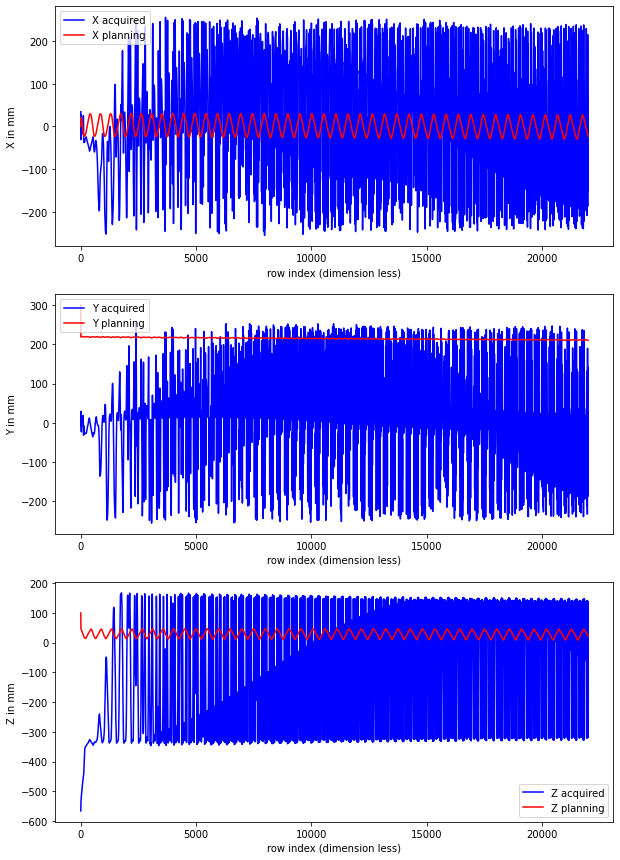

In [112]:
subplotter(0,22000,X,Y,Z,X_inv,Y_inv,Z_inv)

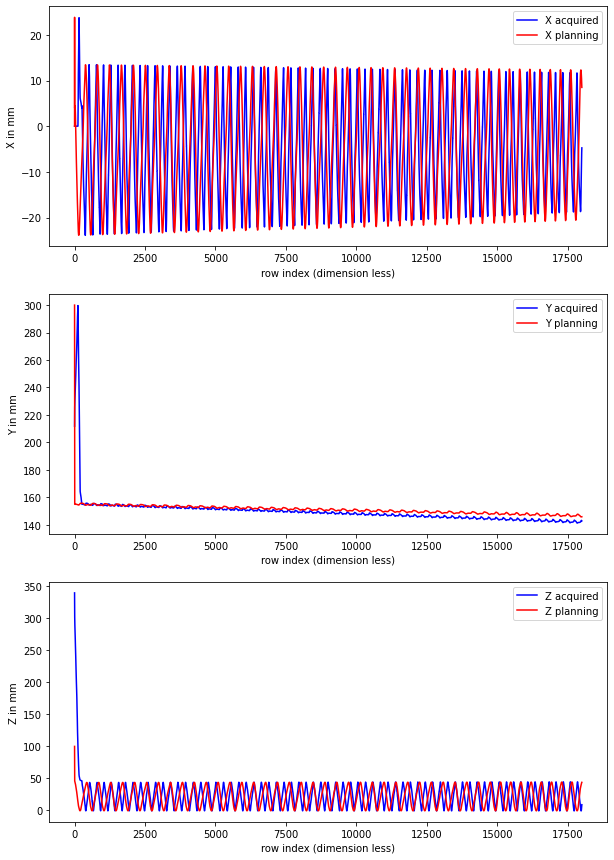

In [89]:
df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/96-6030-0.parquet')
#df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/0-1030-0.parquet')
angle = 96-15
df_p = pd.read_csv('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Toolpath/OP6030_TD_and_WD.csv',delimiter= ';')

df_m = df_m.rename(columns=df_m.iloc[0])
df_m = df_m.iloc[1: , :]

tool_tip_X = df_p['X_TTP Q [mm]'].to_numpy()
tool_tip_Y = df_p['Y_TTP  [mm]'].to_numpy()
tool_tip_Z = df_p['Z_TTP  [mm]'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

wcx = pd.to_numeric(df_m['DynamicData     WcX']).to_numpy()
wcy = pd.to_numeric(df_m['DynamicData     WcY']).to_numpy()
wcz = pd.to_numeric(df_m['DynamicData     WcZ']).to_numpy()

size = wcx.shape[0]
ones = np.ones((size,))
zeros = np.zeros((size,))

init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                    [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                    [zeros,                            zeros,                           ones,  zeros],
                    [zeros,                             zeros,                          zeros, ones]])

machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

forward_transformation = np.transpose(init_C, (2,0,1))
tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]

subplotter(0,18000,X,Y,Z,X_inv,Y_inv,Z_inv)